In [52]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from PIL import Image
import plotly.express as px
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from surprise import Reader, Dataset, SVD
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
pd.set_option('display.max_columns', 25)

### Goal:
- To implement and compare different movie recommendation techniques, including demographic filtering, content-based filtering, and collaborative filtering, to understand their effectiveness in providing personalized movie suggestions. The notebook will analyze the strengths and limitations of each method using a movie dataset.

### Dataset:
- For this analysis, two datasets from Kaggle have been utilized: the TMDB 5000 Movie Dataset and The Movies Dataset. These datasets provide comprehensive information about movies, including metadata, user ratings, and demographic details, which are essential for implementing demographic filtering, content-based filtering, and collaborative filtering techniques.

### Summary:
- __Demographic Filtering__
    - The demographic recommendation system uses a weighted rating formula to suggest the top 10 movies that are popular among a broad audience. The weighted rating considers both the average rating of a movie and the number of votes it has received, ensuring that movies with higher audience engagement are prioritized.

    - In addition, the notebook provides an option to filter the top 5 movies by genre, allowing users to explore popular movies within a specific category. If location data is available in the dataset, the system can also recommend top movies based on the viewer's location, tailoring the recommendations to regional preferences.
- __Content Based Filtering__
    - In this notebook, two methods are implemented for content-based filtering:

        - __Naive Model Based on Overview and Tagline Only:__
        This simple model uses the movie's overview and tagline as metadata to generate recommendations. By calculating the similarity between the textual descriptions of movies, the model suggests movies with similar content to a given movie based on its overview and tagline.

        
        - __Model Based on Movie Cast, Crew, Keywords, and Genre:__
        This advanced model utilizes a broader set of movie metadata, including cast, crew, keywords, and genre, to enhance recommendation quality. By combining these elements, the model captures a more comprehensive view of a movie's content and provides more refined recommendations based on the similarity of these attributes to a user's preferred movie.
- __Collaborative Filtering:__
    - For collaborative filtering, we need user-specific data such as user IDs and their movie ratings. To implement this, another dataset that includes user IDs along with their movie ratings has been used. This approach focuses on finding patterns in user behavior, identifying similar users, and recommending movies that those similar users have liked.
    - The Singular Value Decomposition (SVD) method is employed for collaborative filtering in this notebook. SVD is a matrix factorization technique that helps in decomposing the user-item interaction matrix (user ratings of movies) into three matrices. These matrices capture latent factors that represent the relationship between users and movies. By approximating the original matrix with these latent factors, the SVD method can predict a user's rating for a movie they haven't watched yet. Based on these predictions, the model suggests movies that a user is likely to enjoy, thereby providing personalized movie recommendations.

#### Read Data

In [113]:
df_credit = pd.read_csv("tmdb_5000_credits.csv")
df = pd.read_csv("tmdb_5000_movies.csv")
df = df.merge(df_credit, left_on=["id","title"], right_on=["movie_id","title"])



#### Data Cleaning and Feature Extraction

In [114]:
df.drop("movie_id", inplace = True, axis =1)
df["release_date"] = pd.to_datetime(df["release_date"])

In [115]:
j_cols = ['genres', 'keywords', 'production_countries',
                'production_companies', 'spoken_languages', 'cast', 'crew']
for col in j_cols:
    df[col] = df[col].apply(json.loads)

In [116]:
def director_identity(info):
    director = [item["name"] for item in info if item["job"]=="Director"]
    return str.lower(director[0].replace(" ", "_"))  if director else ""

df['director'] = df['crew'].apply(director_identity)

In [117]:
def get_list_items(lst):
    if isinstance(lst,list):
        items = [item["name"] for item in lst]
        if len(items)>3:
            items =  items[:3]
        return  [str.lower(i.replace(" ", "_")) for i in items]
    
# [str.lower(term.replace(" ", "") for term in items)] 

list_cols = ["cast", "genres","keywords"]
for col in list_cols:
    df[col] = df[col].apply(lambda x: get_list_items(x))


In [118]:
df.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,237000000,"[action, adventure, fantasy]",http://www.avatarmovie.com/,19995,"[culture_clash, future, space_war]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[sam_worthington, zoe_saldana, sigourney_weaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",james_cameron
1,300000000,"[adventure, fantasy, action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug_abuse, exotic_island]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[johnny_depp, orlando_bloom, keira_knightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",gore_verbinski
2,245000000,"[action, adventure, crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based_on_novel, secret_agent]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[daniel_craig, christoph_waltz, léa_seydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...",sam_mendes


In [119]:
def get_counter(col):
    words = []
    for item in df[col]:
        words.extend(item)
    # words = Counter(words)
    return words


In [120]:
imdbmask = np.array(Image.open('./logo2.png'))


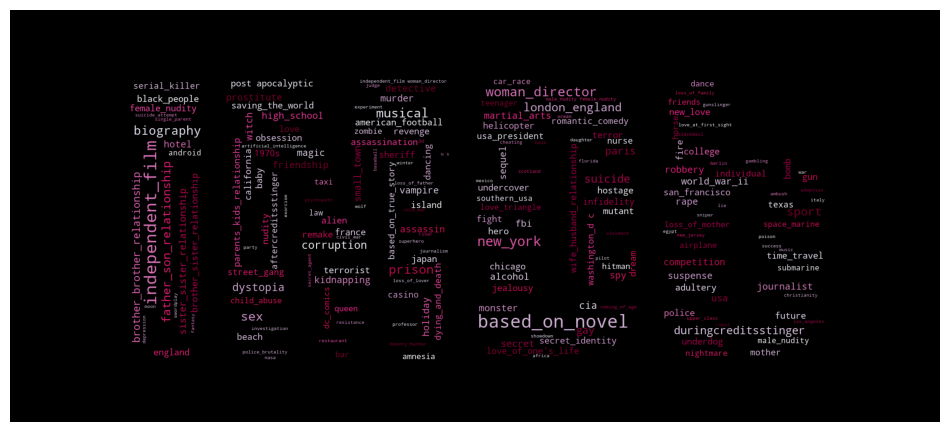

In [121]:
words = get_counter("keywords")
words1 = " ".join(words)
plt.figure(figsize=(12,8))
wc = WordCloud(background_color='black',mask = imdbmask, colormap="PuRd_r",
     width = 400, height = 200).generate(words1)
plt.axis("off")
plt.imshow(wc)

C:\Users\rozit\AppData\Local\Temp\ipykernel_5068\1699818306.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(words2.head(30), x="values", y="keywords", legend=False, palette= "PuRd_r");


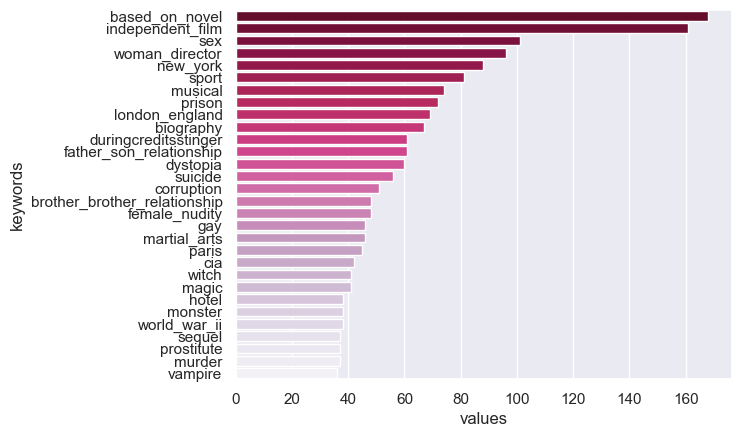

In [122]:

words2 =Counter(words)
words2 = pd.DataFrame.from_dict(words2, orient='index').reset_index().rename(columns={"index":"keywords",0:"values"})
words2.sort_values("values", ascending=False, inplace=True)
sns.set_theme()
sns.barplot(words2.head(30), x="values", y="keywords", legend=False, palette= "PuRd_r");

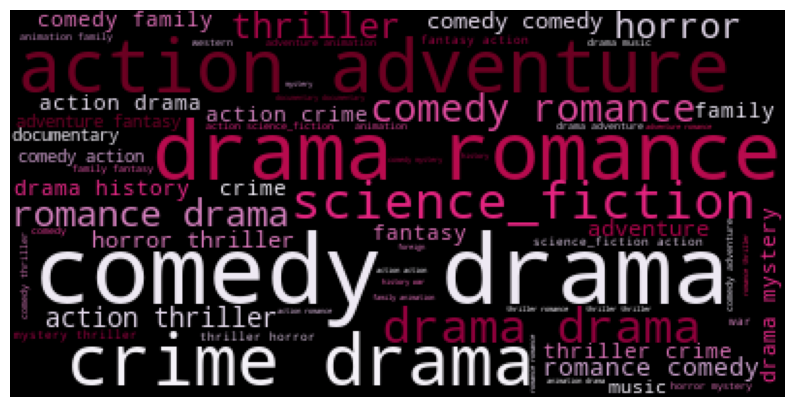

In [123]:

gnr = get_counter("genres")
gnr1 = " ".join(gnr)
plt.figure(figsize=(10,7))
wc = WordCloud(background_color='black', colormap="PuRd_r",
     width = 400, height = 200).generate(gnr1)
plt.axis("off")
plt.imshow(wc)

C:\Users\rozit\AppData\Local\Temp\ipykernel_5068\454518483.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(gnr2.head(30), x="values", y="keywords", legend=False, palette= "PuRd_r");


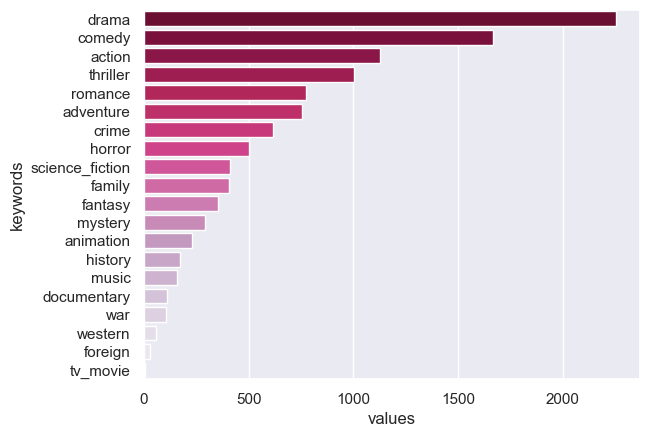

In [124]:

gnr2 =Counter(gnr)
gnr2 = pd.DataFrame.from_dict(gnr2, orient='index').reset_index().rename(columns={"index":"keywords",0:"values"})
gnr2.sort_values("values", ascending=False, inplace=True)
sns.set_theme()
sns.barplot(gnr2.head(30), x="values", y="keywords", legend=False, palette= "PuRd_r");

#### Demographic Filtering (Top 10 Movies in the Region)

- We can recommend movies by considering both their ratings and the number of votes, using a weighted average rating.

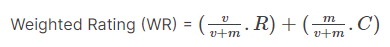

- R: Average rating of the movie
- C: Average vote across all records
- v: Number of votes for the movie
- m: Minimum votes required to be listed in the chart  (Assume 90 percentile as threshold)


In [125]:
C = df["vote_average"].mean()
m = df["vote_count"].quantile(0.90)
print(f"C:{ C:.2f}, m:{ m:.2f}")

C:6.09, m:1838.40


In [126]:
# Qulified movies for the shorted list
demo_df = df.copy()[df["vote_count"]>=m]

In [127]:
def w_rate(df):
    v = df["vote_count"]
    R = df["vote_average"]
    return (R*v/(v+m)) + (C*m/(m+v))

demo_df["w_rate"] = demo_df.apply(w_rate, axis = 1)
demo_df.sort_values("w_rate", ascending = False, inplace = True)


In [128]:
# demo_df[["title","director","w_rate"]].sort_values(by= ["director"])
director_seg = demo_df[["director","w_rate"]].groupby("director", as_index=False).mean().sort_values(by="w_rate",ascending=False)
director_seg["w_rate"] = director_seg["w_rate"].round(2)

- Movie rates segmented by directors:

C:\Users\rozit\AppData\Local\Temp\ipykernel_5068\3987394022.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data = director_seg.head(15), x="w_rate", y="director", legend=False, palette= "PuRd_r");


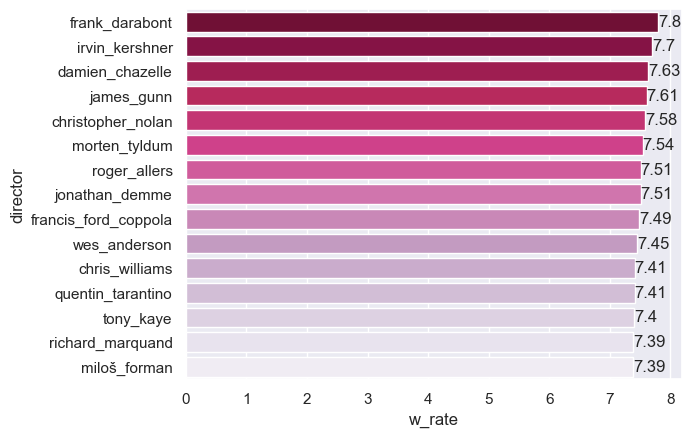

In [129]:
ax = sns.barplot(data = director_seg.head(15), x="w_rate", y="director", legend=False, palette= "PuRd_r");
for i in ax.containers:
    ax.bar_label(i,)

#### Top 10 Movies

- If we have geographic location as a feature, we can segment top 10 movies by region. Here is top 10 popular movies based on rating:

In [130]:
top10 = ( demo_df[["title","director","vote_count", "vote_average","w_rate"]]
                                                         .head(10)
                                                         .reset_index(drop=True) )
top10.style.format({"vote_count":"{:,}","vote_average":'{:.2f}',"w_rate":'{:.2f}'})

,title,director,vote_count,vote_average,w_rate
0,The Shawshank Redemption,frank_darabont,"8,205",8.50,8.06
1,Fight Club,david_fincher,"9,413",8.30,7.94
2,The Dark Knight,christopher_nolan,"12,002",8.20,7.92
3,Pulp Fiction,quentin_tarantino,"8,428",8.30,7.90
4,Inception,christopher_nolan,"13,752",8.10,7.86
5,The Godfather,francis_ford_coppola,"5,893",8.40,7.85
6,Interstellar,christopher_nolan,"10,867",8.10,7.81
7,Forrest Gump,robert_zemeckis,"7,927",8.20,7.80
8,The Lord of the Rings: The Return of the King,peter_jackson,"8,064",8.10,7.73
9,The Empire Strikes Back,irvin_kershner,"5,879",8.20,7.70


- We can also find the top popular movies based on genre. The following function takes the genre and a threshold (minimum rating required) to suggest the top 5 popular movies within that genre.

In [132]:
def extract_top_five(genre, threshold = .8):
    dff = demo_df[demo_df['genres'].apply(lambda x: genre in x)]
    C = dff["vote_average"].mean()
    m = dff["vote_count"].quantile(threshold)
    dff = dff.copy()[dff["vote_count"]>=m]
    dff["w_rate"] = dff.apply(w_rate, axis = 1)
    dff.sort_values("w_rate", ascending = False, inplace = True)
    dff = ( dff[["title","director","vote_count", "vote_average","w_rate"]]
                                                         .head(5)
                                                         .reset_index(drop=True) )
    return dff.style.format({"vote_count":"{:,}","vote_average":'{:.2f}',"w_rate":'{:.2f}'})


##### Top 5 popular comedy movies

In [133]:
extract_top_five(genre="comedy", threshold= 0.8)


,title,director,vote_count,vote_average,w_rate
0,Forrest Gump,robert_zemeckis,"7,927",8.20,7.80
1,Inside Out,pete_docter,"6,560",8.00,7.58
2,Back to the Future,robert_zemeckis,"6,079",8.00,7.56
3,The Wolf of Wall Street,martin_scorsese,"6,571",7.90,7.50
4,The Grand Budapest Hotel,wes_anderson,"4,519",8.00,7.45


##### Top 5 popular drama movies

In [134]:
extract_top_five(genre="drama", threshold= 0.8)


,title,director,vote_count,vote_average,w_rate
0,The Shawshank Redemption,frank_darabont,"8,205",8.50,8.06
1,Fight Club,david_fincher,"9,413",8.30,7.94
2,The Dark Knight,christopher_nolan,"12,002",8.20,7.92
3,The Godfather,francis_ford_coppola,"5,893",8.40,7.85
4,Interstellar,christopher_nolan,"10,867",8.10,7.81


- Another way to recommend movies is by using the popularity feature:

In [135]:
(df.sort_values("popularity", ascending= False)[["title","vote_count", "vote_average","popularity"]]
                                                                        .head(10)
                                                                        .reset_index(drop=True)
                                                                        .style.format({"popularity":"{:.2f}","vote_average":"{:.2f}"}))

,title,vote_count,vote_average,popularity
0,Minions,4571,6.40,875.58
1,Interstellar,10867,8.10,724.25
2,Deadpool,10995,7.40,514.57
3,Guardians of the Galaxy,9742,7.90,481.10
4,Mad Max: Fury Road,9427,7.20,434.28
5,Jurassic World,8662,6.50,418.71
6,Pirates of the Caribbean: The Curse of the Black Pearl,6985,7.50,271.97
7,Dawn of the Planet of the Apes,4410,7.30,243.79
8,The Hunger Games: Mockingjay - Part 1,5584,6.60,206.23
9,Big Hero 6,6135,7.80,203.73


#### Content Based Filtering

- Two content based recommender will be built:
    1. Naive Model Based on Overview and Tagline Only
    2. Model based on Movie Cast, Crew, Keywords and Genre

#####     1. Naive Model Based on Overview and Tagline Only


In [138]:
df["overview"].fillna("", inplace=True)
df["tagline"].fillna("", inplace=True)
df["desc"] = df["overview"] + df["tagline"]

C:\Users\rozit\AppData\Local\Temp\ipykernel_5068\546714641.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["overview"].fillna("", inplace=True)
C:\Users\rozit\AppData\Local\Temp\ipykernel_5068\546714641.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

-  Compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each.
- I will use cosine similarity to calculate similarity between movies

In [139]:
# find similarity matrix
tf = TfidfVectorizer(analyzer='word', stop_words='english')
tf_matrix = tf.fit_transform(df["desc"])
cosine_similarity = linear_kernel(tf_matrix, tf_matrix)

In [25]:
# mapping titles to indices
df_ind = pd.Series(df.index, index=df['title'])

In [26]:
def content_rec(title, matrix = cosine_similarity ):
    ind = df_ind[title]
    # List of similarity scores for the movie (title)
    scores = sorted(list(enumerate(matrix[ind])), key = lambda x: x[1], reverse= True)
    scores = scores[1:11]
    return df["title"].iloc[[score[0] for score in scores]].to_frame()


In [27]:
content_rec("Fight Club")

,title
3619,UHF
697,The Truman Show
2585,The Hurt Locker
2828,Project X
2344,Raging Bull
4053,Friday the 13th: A New Beginning
4718,A Dog's Breakfast
1971,Nurse Betty
2023,The Animal
4044,Go for It!


In [28]:
content_rec("Interstellar")

,title
1709,Space Pirate Captain Harlock
220,Prometheus
300,Starship Troopers
1352,Gattaca
4353,The Green Inferno
634,The Matrix
539,Titan A.E.
643,Space Cowboys
1531,Moonraker
2260,All Good Things


#####     2. Model based on Movie Cast, Crew, Keywords and Genre

In [178]:
# considering more movie metadata
def combined(df):
    return " ".join(df["keywords"]) + " " + " ".join(df["genres"]) + " " + " ".join(df["cast"]) + " " + " ".join(df["director"])


In [179]:
df["comb"] = df.apply(combined, axis = 1)
cnt = CountVectorizer(stop_words='english')
cnt_matrix = cnt.fit_transform(df["comb"])
cosine_similarity2 = linear_kernel(cnt_matrix, cnt_matrix)
content_rec(title = "Fight Club", matrix = cosine_similarity2)

,title
45,World War Z
100,The Curious Case of Benjamin Button
145,Troy
248,Mr. & Mrs. Smith
377,The Devil's Own
407,Meet Joe Black
456,Fury
571,Inglourious Basterds
592,Seven Years in Tibet
928,Moneyball


In [150]:
content_rec(title = "Interstellar", matrix = cosine_similarity2)

,title
270,The Martian
363,A.I. Artificial Intelligence
2375,Midnight Special
39,TRON: Legacy
43,Terminator Salvation
93,Terminator 3: Rise of the Machines
108,Terminator Genisys
123,The Matrix Revolutions
125,The Matrix Reloaded
176,The Revenant


In [192]:
def get_movie_content(title):
    movie_idx = df_ind[title]
    print(f'Title: {title}, index: {movie_idx}')

    words = cnt.get_feature_names_out()
    _, columns = cnt_matrix[movie_idx].nonzero()
    counts = cnt_matrix[movie_idx].data
    for col, count in zip(columns, counts):
        print(f"column: {col}, keyword: {words[col]}, count: {count}")


- Checking the content of movies by title:

In [193]:
get_movie_content(title = "Fight Club")

Title: Fight Club, index: 662
column: 2446, keyword: drama, count: 1
column: 2477, keyword: dual_identity, count: 1
column: 1098, keyword: brad_pitt, count: 1
column: 8322, keyword: support_group, count: 1
column: 2568, keyword: edward_norton, count: 1
column: 6385, keyword: nihilism, count: 1
column: 5771, keyword: meat_loaf, count: 1


In [194]:
get_movie_content(title = "Interstellar")

Title: Interstellar, index: 95
column: 197, keyword: adventure, count: 1
column: 2446, keyword: drama, count: 1
column: 7706, keyword: science_fiction, count: 1
column: 7688, keyword: saving_the_world, count: 1
column: 544, keyword: anne_hathaway, count: 1
column: 659, keyword: artificial_intelligence, count: 1
column: 2905, keyword: father_son_relationship, count: 1
column: 5729, keyword: matthew_mcconaughey, count: 1
column: 4256, keyword: jessica_chastain, count: 1


#### Collaborative Filtering

In [40]:
# reading another dataset since the current dataset does not have user_id which is necessary for colaborative filtering
df_col = pd.read_csv("ratings_small.csv")
df_col.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


In [59]:
reader = Reader()
data = Dataset.load_from_df(df_col[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8850  0.8962  0.9033  0.9050  0.8941  0.8967  0.0071  
MAE (testset)     0.6817  0.6895  0.6936  0.6960  0.6885  0.6899  0.0049  
Fit time          3.45    3.78    3.40    3.22    3.03    3.38    0.25    
Test time         0.47    0.49    0.37    0.32    0.52    0.43    0.08    


{'test_rmse': array([0.88503605, 0.89617244, 0.90326915, 0.90500699, 0.89407524]),
 'test_mae': array([0.68167053, 0.68949625, 0.69361122, 0.69599248, 0.6885282 ]),
 'fit_time': (3.4483444690704346,
  3.7767186164855957,
  3.3982443809509277,
  3.2203328609466553,
  3.0348358154296875),
 'test_time': (0.46817708015441895,
  0.489595890045166,
  0.3650836944580078,
  0.3157944679260254,
  0.5160300731658936)}

In [60]:
#training on data
df_train = data.build_full_trainset()
svd.fit(df_train)

- Let's consider userId 7:

In [72]:
df_col[df_col["userId"]==7]

,userId,movieId,rating,timestamp
495,7,1,3.0,851866703
496,7,10,3.0,851869035
497,7,21,3.0,851867289
498,7,31,3.0,851868750
499,7,34,4.0,851867861
...,...,...,...,...
578,7,1375,3.0,851869140
579,7,1376,3.0,851869062
580,7,1394,3.0,851867688
581,7,1405,5.0,851866978


- Checking if userId = 7 rated movieId = 100:

In [82]:
df_col[(df_col["userId"]==7) & (df_col["movieId"]==100)]

,userId,movieId,rating,timestamp


- Model prediction of rating movieId = 100 by userId = 7:

In [87]:

svd.predict(7, 1)

Prediction(uid=7, iid=1, r_ui=None, est=3.532677727828562, details={'was_impossible': False})